# Gasoline Price Prediction Using Artificial Neural Networks (ANNs)

Prepared by: Thomas Kearns, 2023

## Introduction

The following is an example of applying PyTorch's Artificial Neural Networking (ANN) framework to a regression problem. In this specific context, gasoline prices are predicted based on a variety of features like refinery operations, gasoline sales and exports and crude quality in the US Gulf Coast (USGC/PADD 3) to assess the utility of ANNs in solving regression problems. A brief summary and analysis are also provided on insights gained from the modelling process and its findings.

## 1. Read in Packages

In [1]:
# PyTorch Packages
import torch
torch.cuda.is_available()
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# API Packages
import requests
import yaml
import json

# DataFrame Packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

/home/tom/anaconda3/envs/pytorchenv_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## 2. Source Data

Data was sourced exclusively from the US Energy Information Administration's (EIA) API V.1. To expand accessibility to larger amounts of data, the API call sought to increase periodicity (especially since price volatility often manifests on short-term basis). Unfortunately many infrastructure and trade flow values are only reported on a monthly basis. While weekly or daily data could be resampled to monthly mean, monthly data is usually reported for these terms anyways. Therefore, monthly data for a 12-year period was collected. 

Label data was considered for multiple price points and it was decided that Conventional Gasoline prices would be used as the target of choice. The US Gulf Coast (USGC)/ PADD 3 was selected as the region from which to collect data for several reasons:

- It is the largest refining and gasoline production region in the US.
- Its location at tidewater means it is easy to export to international markets.
- There is significant storage capacity in region.


Grab feature data that might be relevant to gasoline prices, including:

- **Outages:** In case there are any outages, check on monthly crude distillation unit (CDU) capacity as a proxy for overall refinery outages.
- **Gasoline Inventories:** Also check if gasoline inventories are high or low.
- **Crude Quality:** Check if there are any changes in API Gravity on average for refineries to see if lighter crude density results in more naphtha fractions for making gasoline.
- **Gasoline Exports:** See if amount of gasoline exports abroad impacts product prices.
- **Gasoline Sales:** See if monthly sales result in price fluctuations over time.

### A) API key collection

In [2]:
## API Key Loading
# Load config file with API key
eia_config_file = 'auth.yaml'

# Use YAML to load key as JSON
with open(eia_config_file, 'r') as config_file:
    config = yaml.load(config_file, Loader = yaml.FullLoader)

# Fetch key from JSON
api_key = config['eia']['eia_key']

### B) API call formation

In [3]:
## Refined product and crude oil price API Call

# API key calls and feature names
SERIES_NAMES = ['WTI',
                'regular_gasoline',
                'premium_gasoline',
                'regular_diesel',
                'monthly_cdu_capacity',
                'monthly_gasoline_end_inventories',
                'monthly_crude_input_density',
                'monthly_gasoline_exports',
                'monthly_gasoline_sales'
                ]

SERIES_KEY = ['PET.RWTC.M',
              'PET.EMM_EPMR_PTE_R30_DPG.M',
              'PET.EMM_EPMP_PTE_R30_DPG.M',
              'PET.EMD_EPD2D_PTE_R30_DPG.M',
              'PET.MOCGGP32.M',
              'PET.MG4ST_R30_1.M',
              'PET.MCRAPP32.M',
              'PET.MG4EX_R30-Z00_2.M',
              'PET.A103R30001.M'
]

# Initialize list - this is the final list that you will store all the data from the json pull
# Then you will use this list to concat into a pandas dataframe
final_data = []

# Pull in data via EIA API
for i in range(len(SERIES_KEY)):
    url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + SERIES_KEY[i]    
    
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', SERIES_NAMES[i]])   
    
    df.set_index('Date', drop = True, inplace = True)
    final_data.append(df)

# Combine all the data into one dataframe
df = pd.concat(final_data, axis=1)



Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!


/home/tom/anaconda3/envs/pytorchenv_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### C) Create DateTime features and indexing for Exploratory Data Analysis (EDA)

In [4]:
# Choose start and end dates
start_date = '2010-01-01'
end_date = '2022-11-30'

# Create date as datetype datatype for joining
df['Year'] = df.index.astype(str).str[:4]
df['Month'] = df.index.astype(str).str[4:]
df['Day'] = 1
df['Date'] = pd.to_datetime(df[['Year','Month','Day']])
df.set_index('Date', drop = True, inplace = True)
df.sort_index(inplace = True)
df = df[start_date:end_date]

In [5]:
# Convert refined product prices to $/b
fuel_list = ['regular_gasoline', 'premium_gasoline', 'regular_diesel']
g_to_b_convert = 0.0238095

# Loop over columns to convert vectors
for col in fuel_list:
    df[[col]] = df[[col]] / g_to_b_convert

# Round to two significant digits
df = df.round(decimals = 2)

## 3. Exploratory Data Analysis (EDA)

### A) Crude/Refined Product Prices

Generally speaking, gasoline prices are significantly influenced by crude oil prices, because crude is the feedstock from which gasoline is made. Therefore, if crude prices fluctuate, there should be some amount (potentially most) of explanatory power for movement in gasoline prices. However, as you can see in the chart below, crude prices do not exclusively define gasoline prices, as the differential between crude and gasoline can widen or narrow, depending on other factors (e.g. high crude prices might lead to high gasoline prices, which in turn causes weakening demand as fewer people fill up at the pump due to prohibitive costs). Therefore, while these are a critical component of the model, we should make sure to include additional features.

Text(0, 0.5, '$/b')

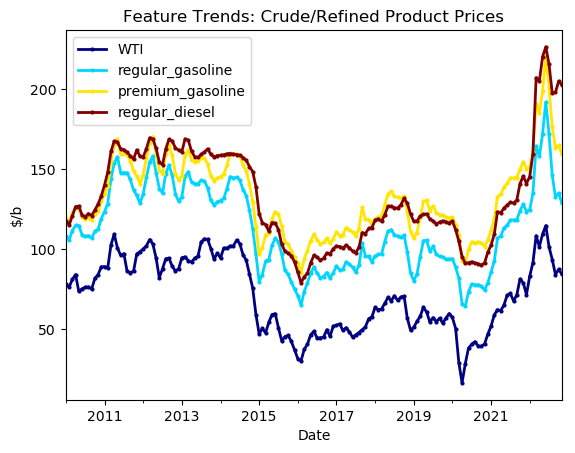

In [6]:
ax = df[['WTI', 'regular_gasoline', 'premium_gasoline', 'regular_diesel']].plot(lw=2, colormap='jet', marker='.', markersize = 4, title='Feature Trends: Crude/Refined Product Prices')
ax.set_ylabel('$/b')

### B) Refinery Outages (Crude Distillation Unit (CDU) Capacity)

If refineries go offline for planned or unplanned maintenance, then demand must be met by gasoline in storage. Since draw downs in these inventories are not being replenished at the same rate, with fewer refineries making gasoline during outages, there may be a corresponding spike in prices as demand must be met from inventories and or imports (these may arrive via pipeline or rail from other regions or by tanker). Therefore, where large dips in crude distillation unit (CDU, the main intake for crude oil into a refinery), prices may respond in kind. Noteworth drops below include during significant winter storms or hurricanes.

Text(0, 0.5, 'k b/d')

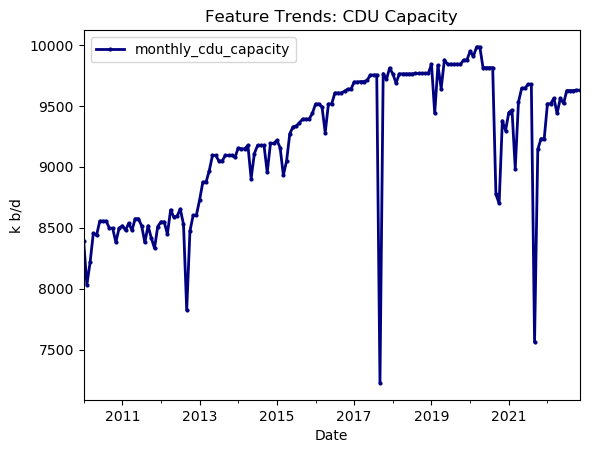

In [7]:
ax = df[['monthly_cdu_capacity']].plot(lw=2, colormap='jet', marker='.', markersize = 4, title='Feature Trends: CDU Capacity')
ax.set_ylabel('k b/d')

### C) Crude Feedstock Density

The amount of gasoline, diesel and other products you can produce from crude will depend on what kind of crude you are processing. Generally, lighter crudes such as light tight oil (LTO) produced in the Bakken, Permian and other tight oil plays in the US are lighter in density and have greater shares of naphtha fractions, which are a rich feedstock for gasoline production. Therefore, as refineries process lighter crude over time, all else being equal, they should find it easier to yield more gasoline compared to other fuels which utilize other fractions like distillates (e.g. diesel), kerosene (jet fuel) and barrel bottoms (fuel oil).

That being said, refineries in the US Gulf Coast (USGC) from which we are deriving statistics, are also optimized to process lower value vacuum residue used for fuel oil or asphalt production, into greater quantities of products like distillates. Therefore, while a higher API gravity does denote potential for greater gasoline production, it also results in refinery imbalances which can yield suboptimal production economics, and cause, for example, too much gasoline production and not enough distillates output. As you can see below, this feedslate has gotten lighter over time and should yield more gasoline, but refinery run rates may have also declined offsetting the trend towards lighter crude processing.

Text(0, 0.5, 'API Gravity')

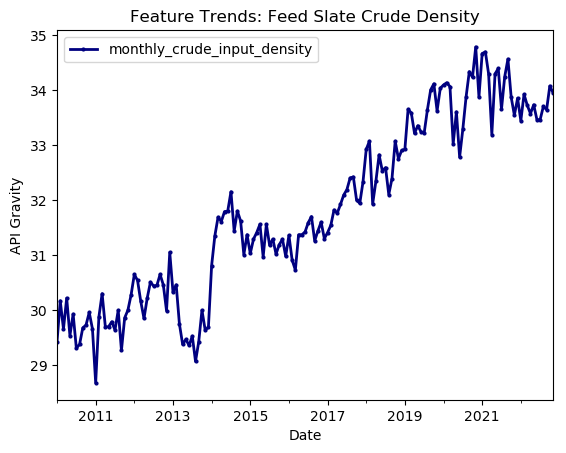

In [8]:
ax = df[['monthly_crude_input_density']].plot(lw=2, colormap='jet', marker='.', markersize = 4, title='Feature Trends: Feed Slate Crude Density')
ax.set_ylabel('API Gravity')

### D) Gasoline Inventory Trends

As mentioned above, if refineries go offline for planned turnaround maintenance or face unplanned outages due to required repairs, or if refinery run rates decline faster than demand, or demand rises faster than production, then a corresponding draw down in gasoline product inventories can occur. This has been the case in the USGC where significant exports of refined products have occurred over time, in particular as Latin America and other regions purchase product produced in the region. Lower inventories should result in a tighter regional market balance and potential risk of higher prices.

Text(0, 0.5, 'mb')

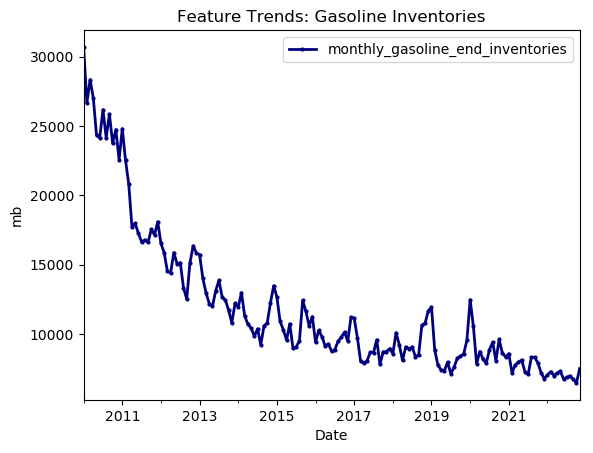

In [9]:
ax = df[['monthly_gasoline_end_inventories']].plot(lw=2, colormap='jet', marker='.', markersize = 4, title='Feature Trends: Gasoline Inventories')
ax.set_ylabel('mb')

### E) Gasoline Exports

As noted before, strong demand for refined products abroad can result in higher exports and inventory draw down, where a tighter market balance results in greater price volatitlity and potentially upside pressure.

Text(0, 0.5, 'k b/d')

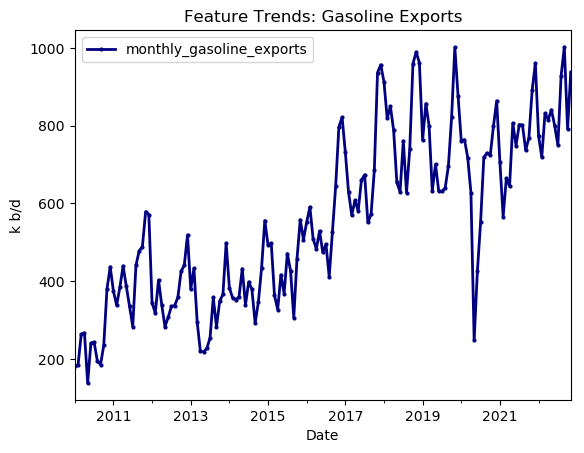

In [10]:
ax = df[['monthly_gasoline_exports']].plot(lw=2, colormap='jet', marker='.', markersize = 4, title='Feature Trends: Gasoline Exports')
ax.set_ylabel('k b/d')

### F) Gasoline Sales

Higher gasoline sales denotes greater product demand. Despite the fact US refined product consumption has generally declined over time, gasoline sales have grown. Temporal disruptions such as the global pandemic can also have significant impact on product demand, as can be seen below in 2020, and again in 2021, which is likely a combination of lockdown and potentially weather related activities.

Text(0, 0.5, 'k b/d')

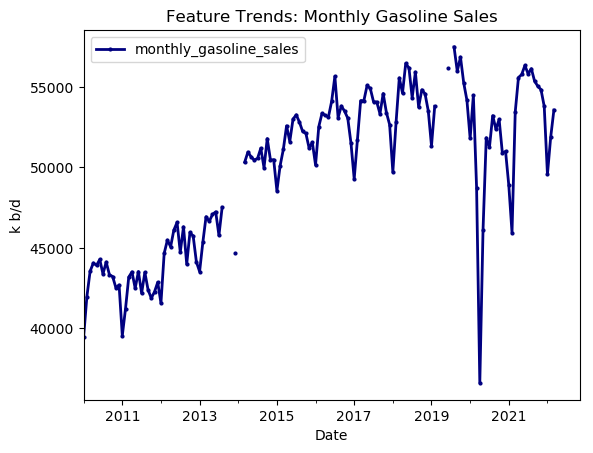

In [11]:
ax = df[['monthly_gasoline_sales']].plot(lw=2, colormap='jet', marker='.', markersize = 4, title='Feature Trends: Monthly Gasoline Sales')
ax.set_ylabel('k b/d')

## 4. Feature Engineering

As you can see above from demand, gasoline consumption is highly seasonal in North America, with a peak during summer driving season, which falls off as winter months approach and people remain indoors more often. For this reason, the main feature to engineer for should be temporal and can include extraction of annual and monthly to denote time of year and quarterly as an approximate proxy for seasonality (e.g. 4 seasons, 4 quarters).

In [13]:
# Drop day column as not needed for features
df = df.drop(columns = 'Day')

# Date Features
df['date'] = df.index
df['Quarter'] = df['date'].dt.quarter
df = df.drop(columns = 'date')

## 5. Model Preparation

The following process uses **PyTorch** to build an **Artificial Neural Network (ANN)** with two hidden layers and regression capabilities to predict gasoline prices based on the feature data. The structure is based on a methodology espoused by **Fast.AI** and **Pierian Data** for whom credit is due.

### A) Encode Categorical and Continuous Features

Similar to SKLearn pipelines, features must be broken out into categorical and continuous groupings and encoded for processing by the ANN.

In [14]:
# Define numeric features
cont_cols = ['WTI',
            'premium_gasoline',
            'regular_diesel',
            'monthly_cdu_capacity',
            'monthly_gasoline_end_inventories',
            'monthly_crude_input_density',
            'monthly_gasoline_exports',
            'monthly_gasoline_sales',
            ]

# Define categorical features
cat_cols = ['Year',
            'Month',
            'Quarter',
            ]

# Define target/label column
y_col = ['regular_gasoline',]

Encode categorical features into category format provided by Pandas.

In [15]:
# Convert categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

Convert the categorical columns into a numpy array and then stack them together and convert into a torch tensor (similar to SKLearn's OrdinalEncoder).

In [16]:
# Convert categorical features into pytorch tensor
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype = torch.long)

Perform same step for numeric features, but normalize distribution to improve model performance (similar to SKLearn's StandardScaler).

In [17]:
# Convert continuous variables to a pytorch tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[7.8330e+01, 1.1966e+02, 1.1789e+02, 8.3920e+03, 3.0694e+04, 2.9430e+01,
         1.8200e+02, 3.9485e+04],
        [7.6390e+01, 1.1689e+02, 1.1533e+02, 8.0310e+03, 2.6650e+04, 3.0170e+01,
         1.8300e+02, 4.1964e+04],
        [8.1200e+01, 1.2281e+02, 1.2088e+02, 8.2160e+03, 2.8336e+04, 2.9660e+01,
         2.6300e+02, 4.3541e+04],
        [8.4290e+01, 1.2587e+02, 1.2676e+02, 8.4550e+03, 2.7005e+04, 3.0220e+01,
         2.6700e+02, 4.4058e+04],
        [7.3740e+01, 1.2583e+02, 1.2705e+02, 8.4370e+03, 2.4309e+04, 2.9540e+01,
         1.3800e+02, 4.3914e+04]])

Convert targets/labels into a PyTorch tensor.

In [18]:
# Convert labels to a pytorch tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y[:5]

tensor([[108.6100],
        [105.7600],
        [111.7600],
        [114.9500],
        [114.8300]])

### B) Set model embeddings

Embeddings are part of the encoding process for data that will be fed into an ANN model, and provide a means of representing the data in a dense vector of higher dimensions. There is a balance between representing complexity and variety of data as well as not overcomplicating the diversity so as to cause difficulty in tracking trends and potentially risking overfitting your model on training data at the expense of later predictive capacity. One rule of thumb employed, can be to take the minimum of a total number of categories divided in half and the number 50. Below, for years,the first 13 refers to the number of years in the dataset (2010-22), for which 7 is the approx. halfed amount. The second number, 12 refers to the number of months in a year (January to December) and the third column to quarters (4 quarters in a year).

In [19]:
cat_cols

['Year', 'Month', 'Quarter']

In [20]:
# This will set embedding sizes for year, month and quarter
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(13, 7), (12, 6), (4, 2)]

### C) Define ANN model in specialized class

In [21]:
# Define class for tabular model in PyTorch
class TabularModel(nn.Module):

    # Instantiate model, including references to general model terms
    # such as embeddings, drop-out (a penalty that deactivates neurons
    # if an activation threshold is not met)
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Define input layer, including neuron count (should be # of cat/num cols)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Create hidden layers based on linear format, ReLU activation and 
        # other terms such as drop out functions and batching (how many data points
        # are passed at one time for analysis)
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        # Add hidden layers together in model
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    # Define terms on which forward connection of model layers will occur
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### D) Set seed and instantiate model

Here is where you call the model class above and setup model-wide operating parameters like how you would like to judge error performance (e.g. for regression, for classification you might use CrossEntropyLoss and a Confusion Matrix).

In [22]:
# Define seed for reproducibility
torch.manual_seed(1)

# Instantiate model and input the embeddings, shape of continuous variables, 
# hidden layer dimenssions and activation threshold for neurons
model = TabularModel(emb_szs, conts.shape[1], 1, [75,75], p=0.5)

Criterion is PyTorch speak for error rate measurement. Normally if you're using an SKLearn model pipeline like GridSearchCV or CrossVal, you would set something like "accuracy/F1" here and then watch as it declines as your model error declines.

In [23]:
# Define error rate and optimization method
# Use Means Squared Error (MSE) but square later for RMSE
criterion = nn.MSELoss()

# ADAM Optimizer is among most efficient methods to use
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Here you set how many rows you want to feed to the model at a time and take the train/test split. You can use SKLearn's train_test_split if you would like. I prefer not to shuffle the data since it is a time series model and I would like to preserve the temporal breakdown, testing on later data from a model trained on older data. This will likely decrease the overall model performance given volatility in energy markets in 2022, but it also makes for a more robust model. Overall, my goal was to aim for consistent RMSE across train and test and to experiment with hyperparameters to improve model performance and to minimize RMSE as long as it's consistent between both training and testing.

In [24]:
# Define batch size
batch_size = 40
test_size = int(batch_size * .2)

# Train Test Split
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

### E) Train Model

Int his section, you set up the actual training process, including a count of model iterations (epochs), setting up a list to hold your loss performance (e.g. RMSE on each run). You then run a for loop over the epoch count and adjust the model's weighting and biases based on each pass, backpropagating changes after it assesses RMSE.

In [25]:
# Start clock for model training time
import time
start_time = time.time()

# Set number of model runs and create an empty list to hold RMSE performance
epochs = 500
losses = []

# Loop over data based on epoch count and predict on training data
# Then calculate RMSE and add loss performance to losses list
for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # Only report every 25th run to display RMSE:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    # Reset optimizer and backpropagate results
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Print model performance per 25 passes and model time
print(f'epoch: {i:3}  loss: {loss.item():10.8f}') 
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 132.04614258
epoch:  26  loss: 127.46118927
epoch:  51  loss: 110.98400879
epoch:  76  loss: 76.53894806
epoch: 101  loss: 24.17060661
epoch: 126  loss: 15.45740128
epoch: 151  loss: 16.55318832
epoch: 176  loss: 17.29144096
epoch: 201  loss: 15.67652988
epoch: 226  loss: 17.42050171
epoch: 251  loss: 16.07236290
epoch: 276  loss: 16.72292709
epoch: 301  loss: 16.51378250
epoch: 326  loss: 17.31621361
epoch: 351  loss: 19.48379326
epoch: 376  loss: 15.52240944
epoch: 401  loss: 13.64515686
epoch: 426  loss: 17.65843964
epoch: 451  loss: 13.07032585
epoch: 476  loss: 11.16618252
epoch: 500  loss: 17.43612099

Duration: 1 seconds


### F) Plot error/loss rate

The following chart communicates RMSE performance over epoch count. It can be interpreted as showing a quick improvement in performance until around 100 epoch counts (e.g. the decline from ~130 to ~20 RMSE) and then there is a slow improvement in performance afterwards (e.g. the horizontal line). You can also see this horizontal line is jagged suggsting remaining instability/noise/error in the model, that is likely attributable to factors not built into the model as well as the generally stochastic nature (e.g. somewhat random) of energy price formation. This more or less denotes a horizon of accuracy that is more difficult or impossible to over come, with remaining noise inherent to the market. 

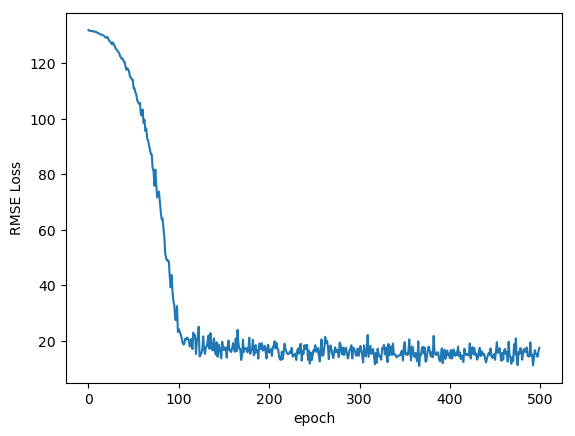

In [26]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

### G) Evaluate model on test data

The model achieves an RMSE of ~20 on test data, roughly equivalent to its strongest average performance on trained data, showing there isn't likely very much overfitting of the model to training data, despite the fact training data comes from an earlier, less volatile period prior to 2022.

In [27]:
# Assess RMSE of model on test data
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 19.59853363


Below is a list of 8 example predictions for prices, showing that the model generally predicts prices ~$10-15/barrel below actual prices. This is likely attributable to volatility and disruption in markets over the last year.

In [28]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(8):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1. 163.3636 152.6700  10.6936
 2. 144.5750 146.3300   1.7551
 3. 118.4520 134.5700  16.1180
 4.  88.9058 130.0700  41.1642
 5. 103.3043 132.8000  29.4957
 6. 155.4535 145.6600   9.7935
 7. 149.7883 148.5100   1.2783
 8. 147.7134 141.9200   5.7934


## 6. Modelling Discussion

The model training and hyperparameter tuning process yielded some interesting discussion points: 

1. **Hidden Layer Neuron Count:** The original model adopted from Pierian Data had a higher neuron count in its hidden layers (~100-200 per layer). It was found that higher neuron counts greatly improved RMSE on training data (as low as $3) but then caused weak performance on test data. This is a sign the model was clearly overfitting on a higher hidden layer count. Once reduced to 25-50 neurons per layer, the model did lose overall RMSE (settling around the current 20) but significantly levelled off, with training and testing achieving fairly close accuracy around 20. This means lowering the hidden layer count helped tame overfitting. I hypothesize the relatively small dataset size (~150 rows) likely limits the ability to apply larger or more complex ANN's (neural networks generally perform better on larger and more complex datasets) and the higher hidden layer neuron count was reading volatility and very short-term trends into the model, which caused weaker performance on testing data.

2. **Batching Size:** Larger batching size improves ability to predict on a greater number of data points, but also weakens model performance compared to a smaller label count. This is likely analogous to the notion of forecasting the price one month ahead versus a year ahead. It is easy to guess what the gasoline price will be tomorrow compared to this week's gas prices, than to estimate where it will land three months from now based on what the prices were for the last few months.